In this notebook we will try methods inspired in the [deep docking method](https://onlinelibrary.wiley.com/doi/full/10.1002/minf.202000028) applied to the cytochromes dataset. For training and testing we will use the data set of shared compounds between isoforms 2c9 and 3a4, while the molecules that are only tested against one of the isoforms will be used as a validation dataset.

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from itertools import product
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
%load_ext tensorboard
matplotlib.rcParams.update({'font.size': 24})

PATH_DATA = "../datasets/CYP/"
hyperparam_tunning = True

In [2]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
validation_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_validation_2c9 = (validation_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
validation_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_validation_3a4 = (validation_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

We need to generate the features for the data sets, we will use RDKits fingerprints.

In [3]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = Chem.RDKFingerprint(mol)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [4]:
if os.path.exists(os.path.join("features", "shared_set_features_RDKIT.npy")):
    features_shared = np.load(os.path.join("features", "shared_set_features_RDKIT.npy"))
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save(os.path.join("features", "shared_set_features_RDKIT.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_2c9_set_features_RDKIT.npy")):
    features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features_RDKIT.npy"))
else:   
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
    np.save(os.path.join("features", "only_2c9_set_features_RDKIT.npy"), features_only_2c9)
    
if os.path.exists(os.path.join("features", "only_3a4_set_features_RDKIT.npy")):
    features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features_RDKIT.npy"))
else:   
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
    np.save(os.path.join("features", "only_3a4_set_features_RDKIT.npy"), features_only_3a4)

We start fitting a model to the 2c9 isoform only, with 25% of the data to the test set, we will use the other 2c9 data set as validation.

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [6]:
def generate_model(hidden_layers, neurons, dropout, lr, L2, n_bits):
    opt  = tf.keras.optimizers.SGD(lr=lr)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=opt, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    
def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    
def draw_roc_curve(y_score, y_true, figsize=(6,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(3, 10))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete([i for i in range(10,151,20)]))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))

    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    model.fit(train_data, train_labels, epochs=10, verbose=2)
    _, results = model.evaluate(test_data, test_labels, verbose=0)                                                                                                
    _, results_val = model.evaluate(features_only_2c9, labels_validation_2c9, verbose=0)
    return results, results_val 


def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy, accuracy_val = train_test_model(hparams)
    tf.summary.scalar("accuracy", accuracy, step=1)
    tf.summary.scalar("accuracy_val", accuracy_val, step=1)

In [13]:
os.makedirs("hyperparameters_tunning/RDKIT", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/RDKIT/logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy'), hp.Metric("accuracy_val", display_name="Validation_accuracy")]) 


if hyperparam_tunning:
    session_num = 0
    total_runs = len(HP_NEURONS.domain.values)*len(HP_HIDDEN_LAYERS.domain.values)*len([HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value])*len(HP_OPTIMIZER.domain.values)*len([HP_L2.domain.min_value, HP_L2.domain.max_value])*len(HP_LR.domain.values)
    looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
    for neurons, hidden_lay, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/RDKIT/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

---Starting trial: run_0 of 3360
{'neurons': 10, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 - 7s - loss: 0.6256 - binary_accuracy: 0.6824
Epoch 2/10
221/221 - 7s - loss: 0.5199 - binary_accuracy: 0.7571
Epoch 3/10
221/221 - 7s - loss: 0.4689 - binary_accuracy: 0.7815
Epoch 4/10
221/221 - 7s - loss: 0.4459 - binary_accuracy: 0.7922
Epoch 5/10
221/221 - 7s - loss: 0.4284 - binary_accuracy: 0.8153
Epoch 6/10
221/221 - 7s - loss: 0.3813 - binary_accuracy: 0.8375
Epoch 7/10
221/221 - 7s - loss: 0.3798 - binary_accuracy: 0.8432
Epoch 8/10
221/221 - 7s - loss: 0.3415 - binary_accuracy: 0.8484
Epoch 9/10
221/221 - 7s - loss: 0.3159 - binary_accuracy: 0.8644
Epoch 10/10
221/221 - 7s - loss: 0.2946 - binary_accuracy: 0.8788
---Starting trial: run_1 of 3360
{'neurons': 10, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Epoch 1/10
221/221 - 7s - loss: 1.

KeyboardInterrupt: 

In [14]:
%tensorboard --logdir hyperparameters_tunning/RDKIT/logs/hparam_tuning

After trying some hyperparameters, we recreate one of the high accuracy models

In [15]:
hidden_layers = 8
neurons = 64
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000

model = generate_model(hidden_layers, neurons, dropout, lr, L2, N_BITS)
model.summary()
history = model.fit(train_data, train_labels, epochs=10)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 64)               

74/74 [==============================] - 0s 5ms/step - loss: 0.8025 - binary_accuracy: 0.7410
NER: 0.785, Sensitivity or recall: 0.908, Specificity: 0.662, Precision: 0.560, Correctly calssified: 0.741, MCC: 0.533


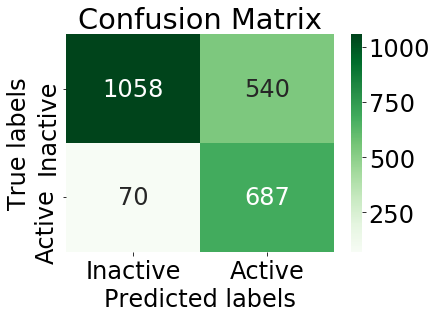

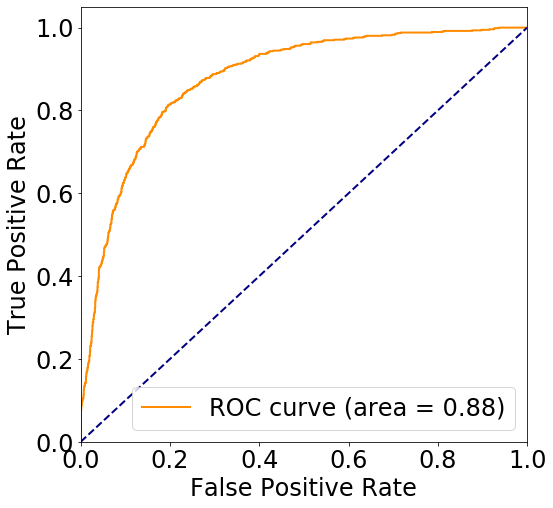

In [16]:
results = model.evaluate(test_data, test_labels)
predictions = model.predict(test_data)
print_metrics(predictions, test_labels);
plot_confusion(predictions, test_labels);
draw_roc_curve(predictions, test_labels, figsize=(8,8))

88/88 [==============================] - 0s 4ms/step - loss: 0.9450 - binary_accuracy: 0.6754
NER: 0.721, Sensitivity or recall: 0.884, Specificity: 0.558, Precision: 0.530, Correctly calssified: 0.675, MCC: 0.433


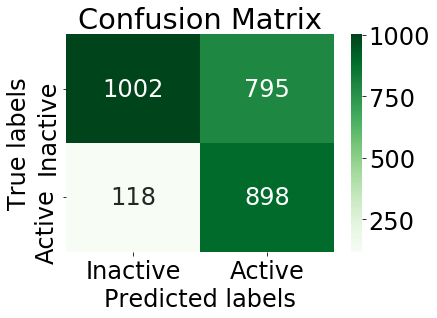

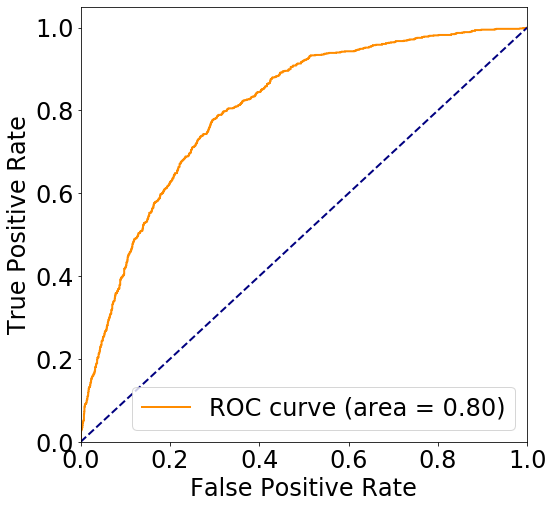

In [17]:
results = model.evaluate(features_only_2c9, labels_validation_2c9)
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_validation_2c9);
plot_confusion(predictions, labels_validation_2c9);
draw_roc_curve(predictions, labels_validation_2c9, figsize=(8,8))

And we do the same for 3a4

In [18]:
train_data_3a4, test_data_3a4, train_labels_3a4, test_labels_3a4 = train_test_split(features_shared, labels_3a4, stratify=labels_3a4)

In [19]:
model = generate_model(hidden_layers, neurons, dropout, lr, L2, N_BITS)
history = model.fit(train_data_3a4, train_labels_3a4, epochs=10)

Epoch 1/10
221/221 [==============================] - 3s 12ms/step - loss: 1.1499 - binary_accuracy: 0.6602
Epoch 2/10
221/221 [==============================] - 2s 11ms/step - loss: 1.0116 - binary_accuracy: 0.7414
Epoch 3/10
221/221 [==============================] - 2s 11ms/step - loss: 0.9260 - binary_accuracy: 0.7699
Epoch 4/10
221/221 [==============================] - 2s 11ms/step - loss: 0.8501 - binary_accuracy: 0.7933
Epoch 5/10
221/221 [==============================] - 3s 11ms/step - loss: 0.7802 - binary_accuracy: 0.8228
Epoch 6/10
221/221 [==============================] - 2s 11ms/step - loss: 0.7402 - binary_accuracy: 0.8280
Epoch 7/10
221/221 [==============================] - 2s 11ms/step - loss: 0.6702 - binary_accuracy: 0.8563
Epoch 8/10
221/221 [==============================] - 2s 11ms/step - loss: 0.6298 - binary_accuracy: 0.8677
Epoch 9/10
221/221 [==============================] - 2s 11ms/step - loss: 0.5791 - binary_accuracy: 0.8787
Epoch 10/10
221/221 [=======

74/74 [==============================] - 0s 4ms/step - loss: 0.6830 - binary_accuracy: 0.7979
NER: 0.792, Sensitivity or recall: 0.768, Specificity: 0.817, Precision: 0.726, Correctly calssified: 0.798, MCC: 0.579


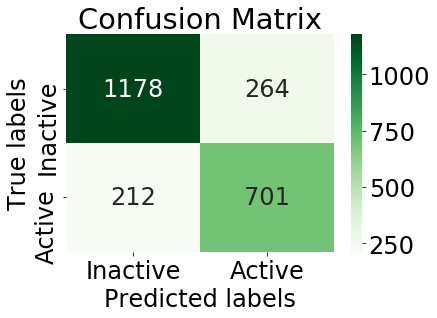

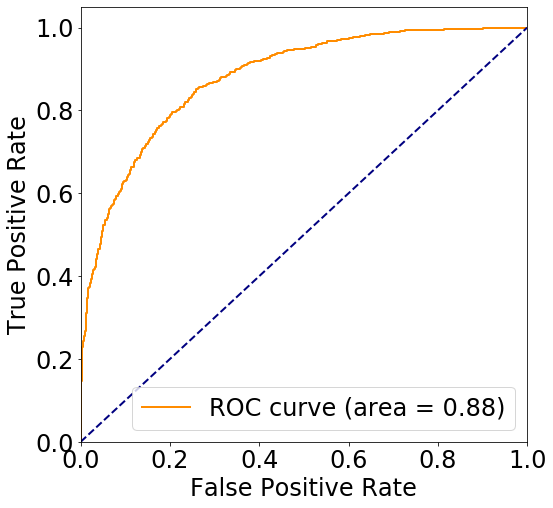

In [20]:
results = model.evaluate(test_data_3a4, test_labels_3a4)
predictions = model.predict(test_data_3a4)
print_metrics(predictions, test_labels_3a4);
plot_confusion(predictions, test_labels_3a4);
draw_roc_curve(predictions, test_labels_3a4, figsize=(8,8))

94/94 [==============================] - 0s 4ms/step - loss: 0.8306 - binary_accuracy: 0.7204
NER: 0.721, Sensitivity or recall: 0.743, Specificity: 0.699, Precision: 0.703, Correctly calssified: 0.720, MCC: 0.442


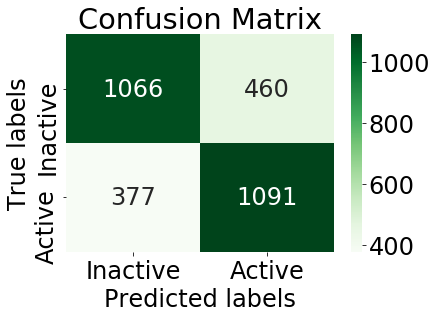

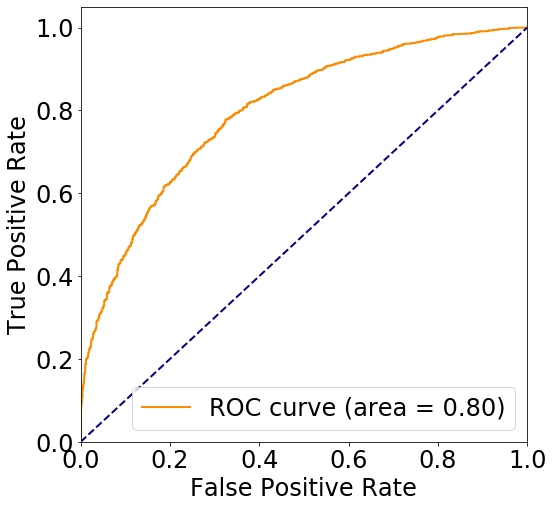

In [21]:
results = model.evaluate(features_only_3a4, labels_validation_3a4)
predictions = model.predict(features_only_3a4)
print_metrics(predictions, labels_validation_3a4);
plot_confusion(predictions, labels_validation_3a4);
draw_roc_curve(predictions, labels_validation_3a4, figsize=(8,8))